## Set GPU

In [1]:
import torch
if torch.cuda.is_available():
    device = 'cuda'
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    device = 'cpu'
print(f'{device=}')

NVIDIA A100-PCIE-40GB
device='cuda'


## Imports

In [2]:
import numpy as np
from gwpy.timeseries import TimeSeries
import pandas as pd
from pathlib import Path
#from lalframe.utils.frtools import get_channels
from os import listdir
#from gwpy.signal import filter_design
from matplotlib import pyplot as plt
from matplotlib import gridspec
from tqdm import tqdm
import time
import json
import os
import ERF
import math
import multiprocessing
import gwpy

In [3]:
import torch
from gwpy.signal.qtransform import QTile as gwpy_QTile
from scipy.interpolate import InterpolatedUnivariateSpline

**Choose either Bicubic (current stable version in ml4gw) or Spline interpolation (still has some border effects due to interpolation and is a bit slower but maches GWpy very closely)**

#### Bicubic (ml4gw) interpolation

In [4]:
from ml4gw.transforms.qtransform import *

#### Spline interpolation

In [4]:
import importlib
import sys
from qtransform_delta import *

# Reload the module, this is useful during developing, debugging and testing
importlib.reload(sys.modules['qtransform'])

<module 'qtransform_delta' from '/home/jovyan/qtransform_delta.py'>

## Load data

In this example we load two 4s long timeseries form LIGO open data and construct an array of timeseries repeating the original time series num_rows times.

the array is both in numpy and torch format respetively for GWpy and custom torch qtransform

In [5]:
sample_rate = 500.0
duration = 6

gps = 1239082262
data = TimeSeries.fetch_open_data('H1', gps-8, gps+8)
data = data.resample(sample_rate)
data = data.whiten()
event = data.crop(gps-duration/2, gps+duration/2)
print(event)

TimeSeries([ 2.55090438,  0.4074086 ,  1.32679891, ...,
             1.13031862,  4.55195388, -0.63746075]
           unit: dimensionless,
           t0: 1239082258.998 s,
           dt: 0.002 s,
           name: Strain,
           channel: None)


In [6]:
sample_rate = 500.0
duration = 6

gps2 = 1239082292
data2 = TimeSeries.fetch_open_data('H1', gps2-8, gps2+8)
data2 = data2.resample(sample_rate)
data2 = data2.whiten()
event2 = data2.crop(gps2-duration/2, gps2+duration/2)
print(event2)

TimeSeries([1.51964058, 1.37374177, 2.02649251, ..., 2.20691029,
            0.62185733, 3.04145228]
           unit: dimensionless,
           t0: 1239082288.998 s,
           dt: 0.002 s,
           name: Strain,
           channel: None)


**Create input with batch size by stacking the same timeseries multiple times**

First stack the two events

In [7]:
event1_values=event.value
event2_values=event2.value
torch_tensor1 = torch.from_numpy(event1_values)
torch_tensor2 = torch.from_numpy(event2_values)

tensor_long = torch.stack([torch_tensor1, torch_tensor2], dim=0)

print(tensor_long)

tensor([[ 2.5509,  0.4074,  1.3268,  ...,  1.1303,  4.5520, -0.6375],
        [ 1.5196,  1.3737,  2.0265,  ...,  2.2069,  0.6219,  3.0415]],
       dtype=torch.float64)


In [8]:
tensor_long.shape

torch.Size([2, 3000])

Increase channel and event dimension via stacking so that the final tensor has the desired dimensions for testing:[2*num_events,num_channels,ts_length]

In [9]:
num_events=100 #actual number of events is 2*num_events as we previously loaded event and event2
num_channels=3
tensor_long_long = tensor_long.unsqueeze(1).repeat(num_events, num_channels, 1)
tensor_long_long.shape

torch.Size([200, 3, 3000])

## Q-transform 

#### SPLINE INTERPOLATION VERSION

In [10]:
#parameters of the Q-transform
frange=(5,100) #frequency range for qtransform expressed in Hz
fres=0.5 #frequency resolution of the transform expressed in  Hz
num_f_bins = int((frange[1] - frange[0]) / fres) #number of frequency bins for the Qtransform
num_t_bins= 200 # number of pixels on time axis of qtransform, to calculate it use: 
#num_t_bins = duration / tres, where tres i time resolution of the transform

q=12 # q value of the qtransform q=f/df


logf=False # logarithmic spacing of frequencies in qtiles
qtiles_mode=False #qtransform returns a list of non interpolated qtiles. Works only in SPline interpolation beta version, not on ml4gw

In [ ]:
#define Qtransform 
qtransform = SingleQTransform(sample_rate=sample_rate, duration=duration, q=q, frange=frange,spectrogram_shape=(num_t_bins,num_f_bins),logf=logf,qtiles_mode=qtiles_mode).to(device) 

#### ML4GW

In [12]:
#parameters of the Q-transform
frange=(5,100) #frequency range for qtransform expressed in Hz
fres=0.5 #frequency resolution of the transform expressed in  Hz
num_f_bins = int((frange[1] - frange[0]) / fres) #number of frequency bins for the Qtransform
num_t_bins= 200 # number of pixels on time axis of qtransform, to calculate it use: 
#num_t_bins = duration / tres, where tres i time resolution of the transform
#interpolation_method='bicubic'
q=12 # q value of the qtransform q=f/df

In [15]:
#define Qtransform for ml4gw VERSION 
qtransform = SingleQTransform(sample_rate=sample_rate, duration=duration, q=q, frange=frange,spectrogram_shape=[num_t_bins,num_f_bins]).to(device) 

In [17]:
start=time.time()
transformed= qtransform(tensor_long_long.to(device),spectrogram_shape=(num_f_bins,num_t_bins)) # as simple as that
end=time.time()
print(f'Time elapsed: {end-start}s')

Time elapsed: 0.04054760932922363s


In [18]:
transformed.shape

torch.Size([200, 3, 190, 200])

## Test transform with interpolation against GWpy

Create a pandas df that has same structure of the aove tensor. This is needed to allow use of multiprocessing when computing Gwpy's transform.

In [23]:
# Generate the data, alternating between event and event2 for each row
data = [[event if i % 2 == 0 else event2 for _ in range(num_channels)] for i in range(num_events)]

# Generate column names based on CH
columns = [f'channel_{i+1}' for i in range(num_channels)]

# Create the DataFrame
df = pd.DataFrame(data, columns=columns)

df.head()

,channel_1,channel_2,channel_3
0,[TimeSeries(2.55090438\n unit: dimen...,[TimeSeries(2.55090438\n unit: dimen...,[TimeSeries(2.55090438\n unit: dimen...
1,[TimeSeries(1.51964058\n unit: dimen...,[TimeSeries(1.51964058\n unit: dimen...,[TimeSeries(1.51964058\n unit: dimen...
2,[TimeSeries(2.55090438\n unit: dimen...,[TimeSeries(2.55090438\n unit: dimen...,[TimeSeries(2.55090438\n unit: dimen...
3,[TimeSeries(1.51964058\n unit: dimen...,[TimeSeries(1.51964058\n unit: dimen...,[TimeSeries(1.51964058\n unit: dimen...
4,[TimeSeries(2.55090438\n unit: dimen...,[TimeSeries(2.55090438\n unit: dimen...,[TimeSeries(2.55090438\n unit: dimen...


In [24]:
def gwpy_qtransform(event, q, logf=True, whiten=False, frange=(5,100)):
    return event.q_transform(qrange=[q, q], logf=logf, whiten=whiten, frange=frange)

#### SPLINE INTERPOLATION VERSION

In [24]:
def compute_transforms(df_event,torch_events,q=12, frange=(5, 100), sample_rate=500.0, qrange=[4, 64], num_t_bins=1000, fres=0.5,plot=True,num_processes=20,logf=False,qtiles_mode=False):
    """
    Compute various types of Q-transforms using both GWpy and PyTorch and visualize the results.

    Inputs:
    - numpy_events (numpy): array of input time series data.
    - torch_events (torch.tensor): tensor of input time series data.
    - q (float): Q-value for the Q-transform. Default vaule is 12
    - frange (tuple, optional): Frequency range for the Q-transform. Default is (5, 100).
    - sample_rate (float, optional): Sampling rate of the input data. Default is 500.0 Hz.
    - qrange (list, optional): Range of Q-values for the Q-scan. Default is [4, 64].
    - num_t_bins (int, optional): Number of time bins for the Q-transform. Default is 1000.
    - fres (float, optional): Frequency resolution for the Q-transform. Default is 0.5.
    - num_processes (int,optional): Number of processes for multiprocess

    Outputs:
    - gwpy_transform (Spectrogram): GWpy Q-transform with single Q-value.
    - transformed (Tensor): Torch Q-transform with single Q-value.
    """
    duration=df_event.iloc[0,0].duration.value
    print(f'{duration=}')
    tres = duration / num_t_bins
    num_f_bins = int((frange[1] - frange[0]) / fres)
    #num_f_bins=500
    f_range = [frange[0], frange[1]]
    

    # Empty cache
    try:
        torch.cuda.empty_cache()
        print('Cache emptied')
    except:
        pass

    # Compute single Q GWpy Q-transform
    #gwpy_transform = event.q_transform(qrange=[q, q], tres=tres, fres=fres, logf=True, whiten=False, frange=frange)
    sgwpy=time.time()


    df_list=df_event.values.flatten().tolist()
    
    args_flatten = [(event, q , logf, False, frange) for event in df_list]
    
    
    with multiprocessing.Pool(num_processes) as pool:
        results=list(tqdm(pool.starmap(gwpy_qtransform,args_flatten),total=len(args_flatten)))
    
    gwpy_transform = np.array(results)
    egwpy=time.time()
    print(f'GWPY qtransform takes {egwpy-sgwpy} s')
    
    print(f'{device=}')
    
    # Compute Torch single Q -transform
    qtransform = SingleQTransform(sample_rate=sample_rate, duration=duration, q=q, frange=frange,spectrogram_shape=(num_t_bins,num_f_bins),logf=logf,qtiles_mode=qtiles_mode).to(device) #,logf=logf,qtiles_mode=qtiles_mode
    storch=time.time()
    transformed= qtransform(tensor_long_long.to(device),spectrogram_shape=(num_f_bins,num_t_bins)) #torch.Tensor(event.value).to(device)
    etorch=time.time()
    print(f'TORCH qtransform takes {etorch-storch} s')
    print(f'{transformed.shape=}')
        
    if plot:
        print(f'{gwpy_transform.shape=}')
        print(f'{type(gwpy_transform)=}')
        # Compute differences between Torch and GWpy Q-transforms
        abs_diff = abs(transformed[0,0].detach().cpu().numpy() - gwpy_transform[0].T)
    
        # Plot Q-transforms
        fig, axes = plt.subplots(1, 3, figsize=(20, 7))
        im0 = axes[0].imshow(gwpy_transform[0].T, aspect="auto", origin="lower", vmin=0, vmax=25,extent=[0, duration, frange[0], frange[1]])
        axes[0].set_title("GWpy   q=12")
        fig.colorbar(im0, ax=axes[0])
    
        im1 = axes[1].imshow(transformed[0,0].cpu().numpy(), aspect="auto", origin="lower", vmin=0, vmax=25,extent=[0, duration, frange[0], frange[1]])
        axes[1].set_title("Torch   q=12")
        fig.colorbar(im1, ax=axes[1])
    
        im2 = axes[2].imshow(abs_diff, aspect="auto", origin="lower", vmin=0, vmax=25,extent=[0, duration, frange[0], frange[1]])
        axes[2].set_title("Abs Difference gwpy/ torch")
        fig.colorbar(im2, ax=axes[2])
        
        for ax in axes:
    
            ax.set_xlabel("Time [s]")
            ax.set_ylabel("Frequency [Hz]")
    
    
        plt.show()
    
        #print out some stats
        
        #print(f'{transformed[0].cpu().numpy()[10:140,:].shape=}')
        #print(f'SIZE GWPY: {gwpy_transform[0].T[10:140,:].shape}')
        #print(f'SIZE TORCH: {transformed.shape}')
        print(f'MAX VALUE OF GWPY: {np.max(gwpy_transform[0].T)}')
        print(f'MAX VALUE OF TORCH: {np.max(transformed[0,0].cpu().numpy())}')
        
        max_value = np.max(transformed[0,0].cpu().numpy())
        max_indices = np.where(transformed[0,0].cpu().numpy() == max_value)

        print(f"COORDINATES OF MAX VALUE TORCH: ({max_indices[1][0]*duration/num_t_bins} s, {frange[0]+max_indices[0][0]*fres} Hz)")
        
        max_value =np.max(gwpy_transform[0].T)
        max_indices = np.where(gwpy_transform[0].T == max_value)
        print(f"COORDINATES OF MAX VALUE GWPY: ({max_indices[1][0]*duration/num_t_bins} s, {frange[0]+max_indices[0][0]*fres} Hz) ")
        
        print(f'MEAN OF TORCH PLOT: {np.mean(transformed[0,0].cpu().numpy())}; STD: {np.std(transformed[0,0].cpu().numpy())}')
        print(f'MEAN OF GWPY PLOT: {np.mean(gwpy_transform[0].T)}; STD: {np.std(gwpy_transform[0].T)}')
        print(f'MEAN OF ABS DIFF PLOT: {np.mean(abs_diff)}; STD: {np.std(abs_diff)} ')
        print(f'MAX OF ABS DIFF PLOT: {np.max(abs_diff)}')
    
    if plot:
        print(f'{gwpy_transform.shape=}')
        print(f'{type(gwpy_transform)=}')
        # Compute differences between Torch and GWpy Q-transforms
        abs_diff = abs(transformed[1,1].detach().cpu().numpy() - gwpy_transform[1].T)
    
        # Plot Q-transforms
        fig, axes = plt.subplots(1, 3, figsize=(20, 7))
        im0 = axes[0].imshow(gwpy_transform[1].T, aspect="auto", origin="lower", vmin=0, vmax=25,extent=[0, duration, frange[0], frange[1]])
        axes[0].set_title("GWpy   q=12")
        fig.colorbar(im0, ax=axes[0])
    
        im1 = axes[1].imshow(transformed[1,1].cpu().numpy(), aspect="auto", origin="lower", vmin=0, vmax=25,extent=[0, duration, frange[0], frange[1]])
        axes[1].set_title("Torch   q=12")
        fig.colorbar(im1, ax=axes[1])
    
        im2 = axes[2].imshow(abs_diff, aspect="auto", origin="lower", vmin=0, vmax=25,extent=[0, duration, frange[0], frange[1]])
        axes[2].set_title("Abs Difference gwpy/ torch")
        fig.colorbar(im2, ax=axes[2])
        
        for ax in axes:
    
            ax.set_xlabel("Time [s]")
            ax.set_ylabel("Frequency [Hz]")
    
    
        plt.show()
    
        #print out some stats
        
        #print(f'{transformed[0].cpu().numpy()[10:140,:].shape=}')
        #print(f'SIZE GWPY: {gwpy_transform[0].T[10:140,:].shape}')
        #print(f'SIZE TORCH: {transformed.shape}')
        print(f'MAX VALUE OF GWPY: {np.max(gwpy_transform[1,0].T)}')
        print(f'MAX VALUE OF TORCH: {np.max(transformed[1].cpu().numpy())}')
        
        max_value = np.max(transformed[1,0].cpu().numpy())
        max_indices = np.where(transformed[1,0].cpu().numpy() == max_value)

        print(f"COORDINATES OF MAX VALUE TORCH: ({max_indices[1][0]*duration/num_t_bins} s, {frange[0]+max_indices[0][0]*fres} Hz)")
        
        max_value =np.max(gwpy_transform[0].T)
        max_indices = np.where(gwpy_transform[0].T == max_value)
        print(f"COORDINATES OF MAX VALUE GWPY: ({max_indices[1][0]*duration/num_t_bins} s, {frange[0]+max_indices[0][0]*fres} Hz) ")
        
        print(f'MEAN OF TORCH PLOT: {np.mean(transformed[1,0].cpu().numpy())}; STD: {np.std(transformed[1,0].cpu().numpy())}')
        print(f'MEAN OF GWPY PLOT: {np.mean(gwpy_transform[0].T)}; STD: {np.std(gwpy_transform[0].T)}')
        print(f'MEAN OF ABS DIFF PLOT: {np.mean(abs_diff)}; STD: {np.std(abs_diff)} ')
        print(f'MAX OF ABS DIFF PLOT: {np.max(abs_diff)}')
        
     
    return gwpy_transform,transformed,egwpy-sgwpy,etorch-storch

In [ ]:
#Define parameters of Qtransform

In [27]:
q = 12 #5.65685424949238 #12
num_t_bins=1000
fres = 0.5
frange=(5,100)
qrange=[12,12]
duration=event.duration.value


duration=6.0
Cache emptied


100%|██████████| 300/300 [00:00<00:00, 2859752.73it/s]


GWPY qtransform takes 13.56004524230957 s
device='cuda'
TORCH qtransform takes 0.618506908416748 s
transformed.shape=torch.Size([200, 3, 190, 1000])
gwpy_transform.shape=(300, 1000, 190)
type(gwpy_transform)=<class 'numpy.ndarray'>


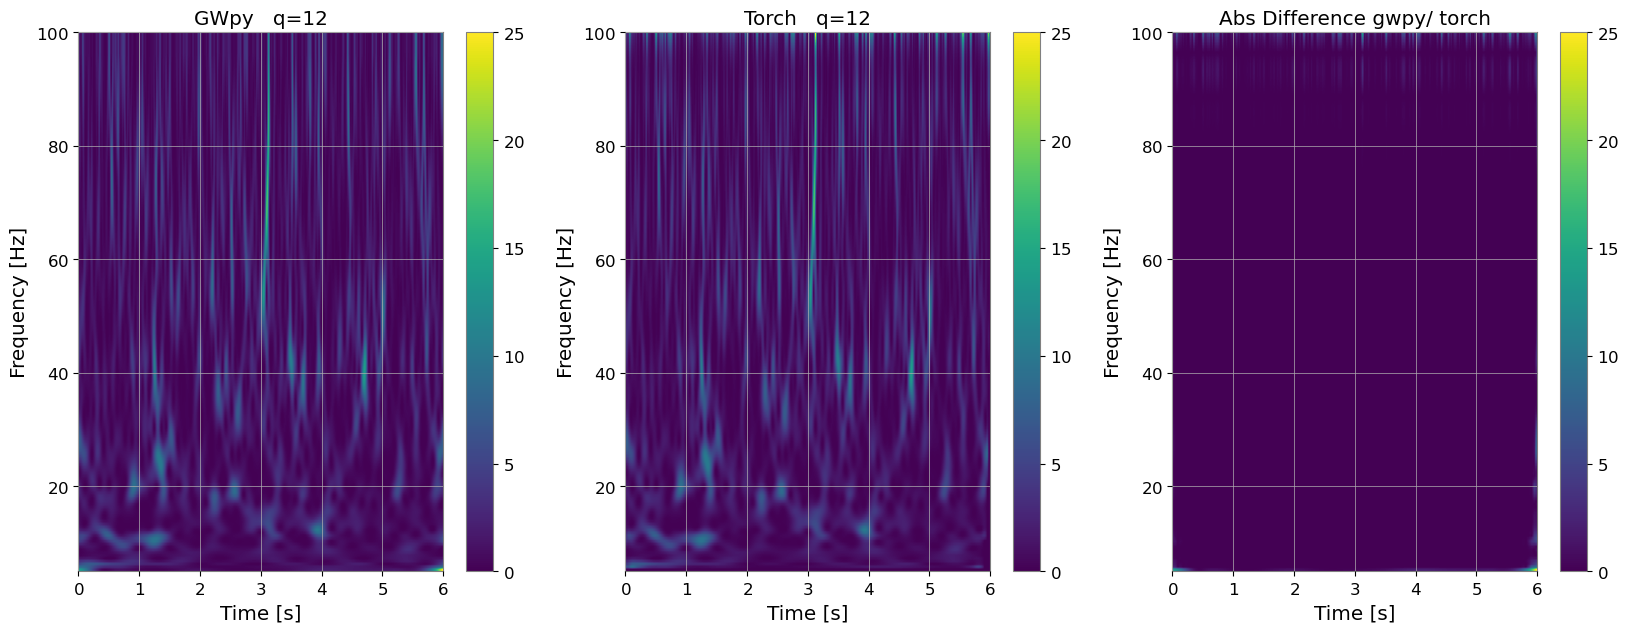

MAX VALUE OF GWPY: 26.004575729370117
MAX VALUE OF TORCH: 30.04887580871582
COORDINATES OF MAX VALUE TORCH: (3.132 s, 99.5 Hz)
COORDINATES OF MAX VALUE GWPY: (5.994 s, 5.0 Hz) 
MEAN OF TORCH PLOT: 1.5333248376846313; STD: 1.7545089721679688
MEAN OF GWPY PLOT: 1.5331716537475586; STD: 1.7138844728469849
MEAN OF ABS DIFF PLOT: 0.09954637289047241; STD: 0.5343549847602844 
MAX OF ABS DIFF PLOT: 26.004575729370117
gwpy_transform.shape=(300, 1000, 190)
type(gwpy_transform)=<class 'numpy.ndarray'>


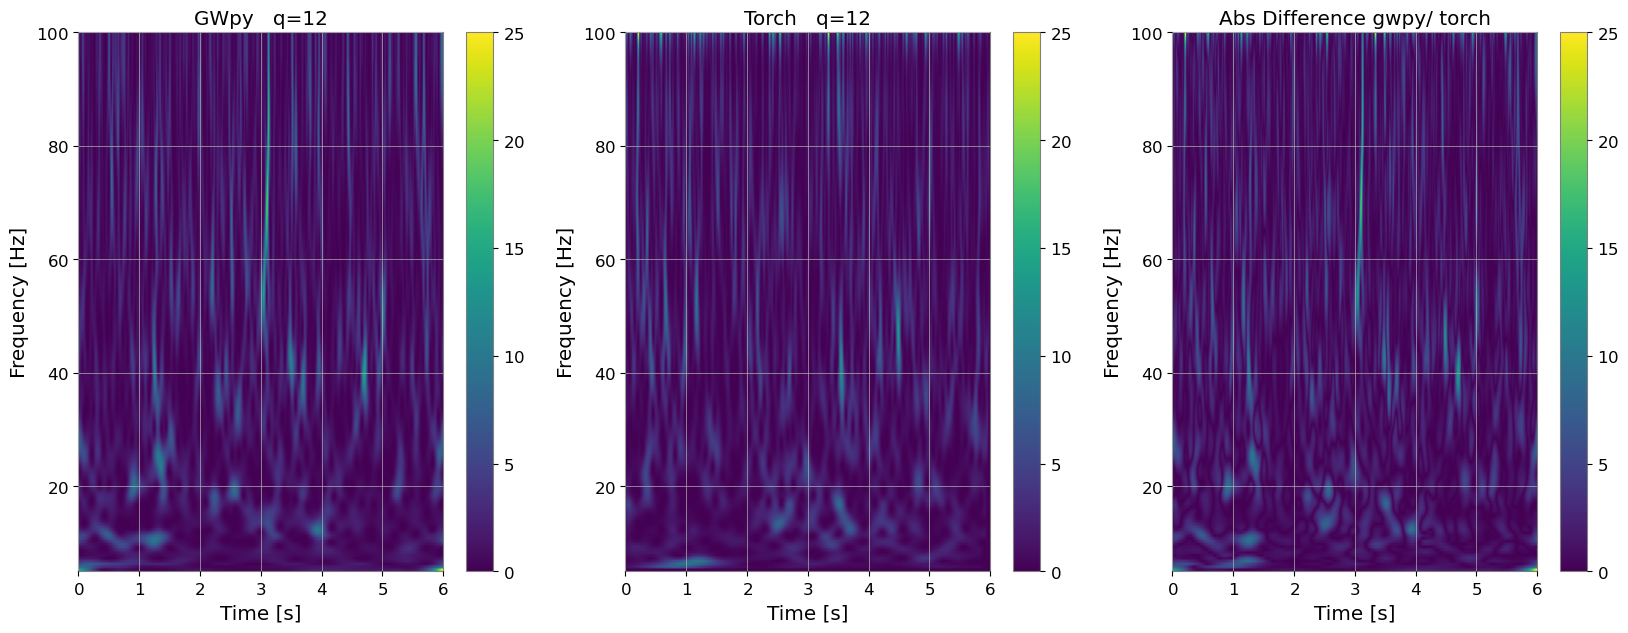

MAX VALUE OF GWPY: 14.357853889465332
MAX VALUE OF TORCH: 31.060420989990234
COORDINATES OF MAX VALUE TORCH: (0.216 s, 99.5 Hz)
COORDINATES OF MAX VALUE GWPY: (5.994 s, 5.0 Hz) 
MEAN OF TORCH PLOT: 1.440568208694458; STD: 1.5238916873931885
MEAN OF GWPY PLOT: 1.5331716537475586; STD: 1.7138844728469849
MEAN OF ABS DIFF PLOT: 1.5180491209030151; STD: 1.7101473808288574 
MAX OF ABS DIFF PLOT: 30.945480346679688
Total time: 15.923288583755493s


In [28]:
#Compute Qtransform
start=time.time() 
gwpy_transform,transformed_2,time_gwpy,time_torch=compute_transforms(df,tensor_long, q=q, frange=frange, sample_rate=sample_rate, qrange=qrange, num_t_bins=num_t_bins, fres=fres,num_processes=1,plot=True,qtiles_mode=False)
end=time.time()
print(f'Total time: {end-start}s')

Try to calculate stats exluding borders, they'll match GWpy's

#### ML4GW

In [45]:
def compute_transforms(df_event,torch_events,q=12, frange=(5, 100), sample_rate=500.0, qrange=[4, 64], num_t_bins=1000, fres=0.5,plot=True,num_processes=20,logf=False,qtiles_mode=False):
    """
    Compute various types of Q-transforms using both GWpy and PyTorch and visualize the results.

    Inputs:
    - numpy_events (numpy): array of input time series data.
    - torch_events (torch.tensor): tensor of input time series data.
    - q (float): Q-value for the Q-transform. Default vaule is 12
    - frange (tuple, optional): Frequency range for the Q-transform. Default is (5, 100).
    - sample_rate (float, optional): Sampling rate of the input data. Default is 500.0 Hz.
    - qrange (list, optional): Range of Q-values for the Q-scan. Default is [4, 64].
    - num_t_bins (int, optional): Number of time bins for the Q-transform. Default is 1000.
    - fres (float, optional): Frequency resolution for the Q-transform. Default is 0.5.
    - num_processes (int,optional): Number of processes for multiprocess

    Outputs:
    - gwpy_transform (Spectrogram): GWpy Q-transform with single Q-value.
    - transformed (Tensor): Torch Q-transform with single Q-value.
    """
    duration=df_event.iloc[0,0].duration.value
    print(f'{duration=}')
    tres = duration / num_t_bins
    num_f_bins = int((frange[1] - frange[0]) / fres)
    #num_f_bins=500
    f_range = [frange[0], frange[1]]
    

    # Empty cache
    try:
        torch.cuda.empty_cache()
        print('Cache emptied')
    except:
        pass

    # Compute single Q GWpy Q-transform
    #gwpy_transform = event.q_transform(qrange=[q, q], tres=tres, fres=fres, logf=True, whiten=False, frange=frange)
    sgwpy=time.time()


    df_list=df_event.values.flatten().tolist()
    
    args_flatten = [(event, q , logf, False, frange) for event in df_list]
    
    
    with multiprocessing.Pool(num_processes) as pool:
        results=list(tqdm(pool.starmap(gwpy_qtransform,args_flatten),total=len(args_flatten)))
    
    gwpy_transform = np.array(results)
    egwpy=time.time()
    print(f'GWPY qtransform takes {egwpy-sgwpy} s')
    
    print(f'{device=}')
    
    # Compute Torch single Q -transform
    qtransform = SingleQTransform(sample_rate=sample_rate, duration=duration, q=q, frange=frange,spectrogram_shape=[num_f_bins,num_t_bins]).to(device)
    storch=time.time()
    transformed= qtransform(tensor_long_long.to(device)) #torch.Tensor(event.value).to(device)
    etorch=time.time()
    print(f'TORCH qtransform takes {etorch-storch} s')
    print(f'{transformed.shape=}')
        
    if plot:
        print(f'{gwpy_transform.shape=}')
        print(f'{type(gwpy_transform)=}')
        # Compute differences between Torch and GWpy Q-transforms
        abs_diff = abs(transformed[0,0].detach().cpu().numpy() - gwpy_transform[0].T)
    
        # Plot Q-transforms
        fig, axes = plt.subplots(1, 3, figsize=(20, 7))
        im0 = axes[0].imshow(gwpy_transform[0].T, aspect="auto", origin="lower", vmin=0, vmax=25,extent=[0, duration, frange[0], frange[1]])
        axes[0].set_title("GWpy   q=12")
        fig.colorbar(im0, ax=axes[0])
    
        im1 = axes[1].imshow(transformed[0,0].cpu().numpy(), aspect="auto", origin="lower", vmin=0, vmax=25,extent=[0, duration, frange[0], frange[1]])
        axes[1].set_title("Torch   q=12")
        fig.colorbar(im1, ax=axes[1])
    
        im2 = axes[2].imshow(abs_diff, aspect="auto", origin="lower", vmin=0, vmax=25,extent=[0, duration, frange[0], frange[1]])
        axes[2].set_title("Abs Difference gwpy/ torch")
        fig.colorbar(im2, ax=axes[2])
        
        for ax in axes:
    
            ax.set_xlabel("Time [s]")
            ax.set_ylabel("Frequency [Hz]")
    
    
        plt.show()
    
        #print out some stats
        
        #print(f'{transformed[0].cpu().numpy()[10:140,:].shape=}')
        #print(f'SIZE GWPY: {gwpy_transform[0].T[10:140,:].shape}')
        #print(f'SIZE TORCH: {transformed.shape}')
        print(f'MAX VALUE OF GWPY: {np.max(gwpy_transform[0].T)}')
        print(f'MAX VALUE OF TORCH: {np.max(transformed[0,0].cpu().numpy())}')
        
        max_value = np.max(transformed[0,0].cpu().numpy())
        max_indices = np.where(transformed[0,0].cpu().numpy() == max_value)

        print(f"COORDINATES OF MAX VALUE TORCH: ({max_indices[1][0]*duration/num_t_bins} s, {frange[0]+max_indices[0][0]*fres} Hz)")
        
        max_value =np.max(gwpy_transform[0].T)
        max_indices = np.where(gwpy_transform[0].T == max_value)
        print(f"COORDINATES OF MAX VALUE GWPY: ({max_indices[1][0]*duration/num_t_bins} s, {frange[0]+max_indices[0][0]*fres} Hz) ")
        
        print(f'MEAN OF TORCH PLOT: {np.mean(transformed[0,0].cpu().numpy())}; STD: {np.std(transformed[0,0].cpu().numpy())}')
        print(f'MEAN OF GWPY PLOT: {np.mean(gwpy_transform[0].T)}; STD: {np.std(gwpy_transform[0].T)}')
        print(f'MEAN OF ABS DIFF PLOT: {np.mean(abs_diff)}; STD: {np.std(abs_diff)} ')
        print(f'MAX OF ABS DIFF PLOT: {np.max(abs_diff)}')
    
    if plot:
        print(f'{gwpy_transform.shape=}')
        print(f'{type(gwpy_transform)=}')
        # Compute differences between Torch and GWpy Q-transforms
        abs_diff = abs(transformed[1,1].detach().cpu().numpy() - gwpy_transform[1].T)
    
        # Plot Q-transforms
        fig, axes = plt.subplots(1, 3, figsize=(20, 7))
        im0 = axes[0].imshow(gwpy_transform[1].T, aspect="auto", origin="lower", vmin=0, vmax=25,extent=[0, duration, frange[0], frange[1]])
        axes[0].set_title("GWpy   q=12")
        fig.colorbar(im0, ax=axes[0])
    
        im1 = axes[1].imshow(transformed[1,1].cpu().numpy(), aspect="auto", origin="lower", vmin=0, vmax=25,extent=[0, duration, frange[0], frange[1]])
        axes[1].set_title("Torch   q=12")
        fig.colorbar(im1, ax=axes[1])
    
        im2 = axes[2].imshow(abs_diff, aspect="auto", origin="lower", vmin=0, vmax=25,extent=[0, duration, frange[0], frange[1]])
        axes[2].set_title("Abs Difference gwpy/ torch")
        fig.colorbar(im2, ax=axes[2])
        
        for ax in axes:
    
            ax.set_xlabel("Time [s]")
            ax.set_ylabel("Frequency [Hz]")
    
    
        plt.show()
    
        #print out some stats
        
        #print(f'{transformed[0].cpu().numpy()[10:140,:].shape=}')
        #print(f'SIZE GWPY: {gwpy_transform[0].T[10:140,:].shape}')
        #print(f'SIZE TORCH: {transformed.shape}')
        print(f'MAX VALUE OF GWPY: {np.max(gwpy_transform[1,0].T)}')
        print(f'MAX VALUE OF TORCH: {np.max(transformed[1].cpu().numpy())}')
        
        max_value = np.max(transformed[1,0].cpu().numpy())
        max_indices = np.where(transformed[1,0].cpu().numpy() == max_value)

        print(f"COORDINATES OF MAX VALUE TORCH: ({max_indices[1][0]*duration/num_t_bins} s, {frange[0]+max_indices[0][0]*fres} Hz)")
        
        max_value =np.max(gwpy_transform[0].T)
        max_indices = np.where(gwpy_transform[0].T == max_value)
        print(f"COORDINATES OF MAX VALUE GWPY: ({max_indices[1][0]*duration/num_t_bins} s, {frange[0]+max_indices[0][0]*fres} Hz) ")
        
        print(f'MEAN OF TORCH PLOT: {np.mean(transformed[1,0].cpu().numpy())}; STD: {np.std(transformed[1,0].cpu().numpy())}')
        print(f'MEAN OF GWPY PLOT: {np.mean(gwpy_transform[0].T)}; STD: {np.std(gwpy_transform[0].T)}')
        print(f'MEAN OF ABS DIFF PLOT: {np.mean(abs_diff)}; STD: {np.std(abs_diff)} ')
        print(f'MAX OF ABS DIFF PLOT: {np.max(abs_diff)}')
        
     
    return gwpy_transform,transformed,egwpy-sgwpy,etorch-storch

In [46]:
#Define parameters of Qtransform

In [47]:
q = 12 #5.65685424949238 #12
num_t_bins=1000
fres = 0.5
frange=(5,100)
qrange=[12,12]
duration=event.duration.value


duration=6.0
Cache emptied


100%|██████████| 300/300 [00:00<00:00, 2821280.72it/s]


GWPY qtransform takes 13.811971664428711 s
device='cuda'
TORCH qtransform takes 0.01727914810180664 s
transformed.shape=torch.Size([200, 3, 190, 1000])
gwpy_transform.shape=(300, 1000, 190)
type(gwpy_transform)=<class 'numpy.ndarray'>


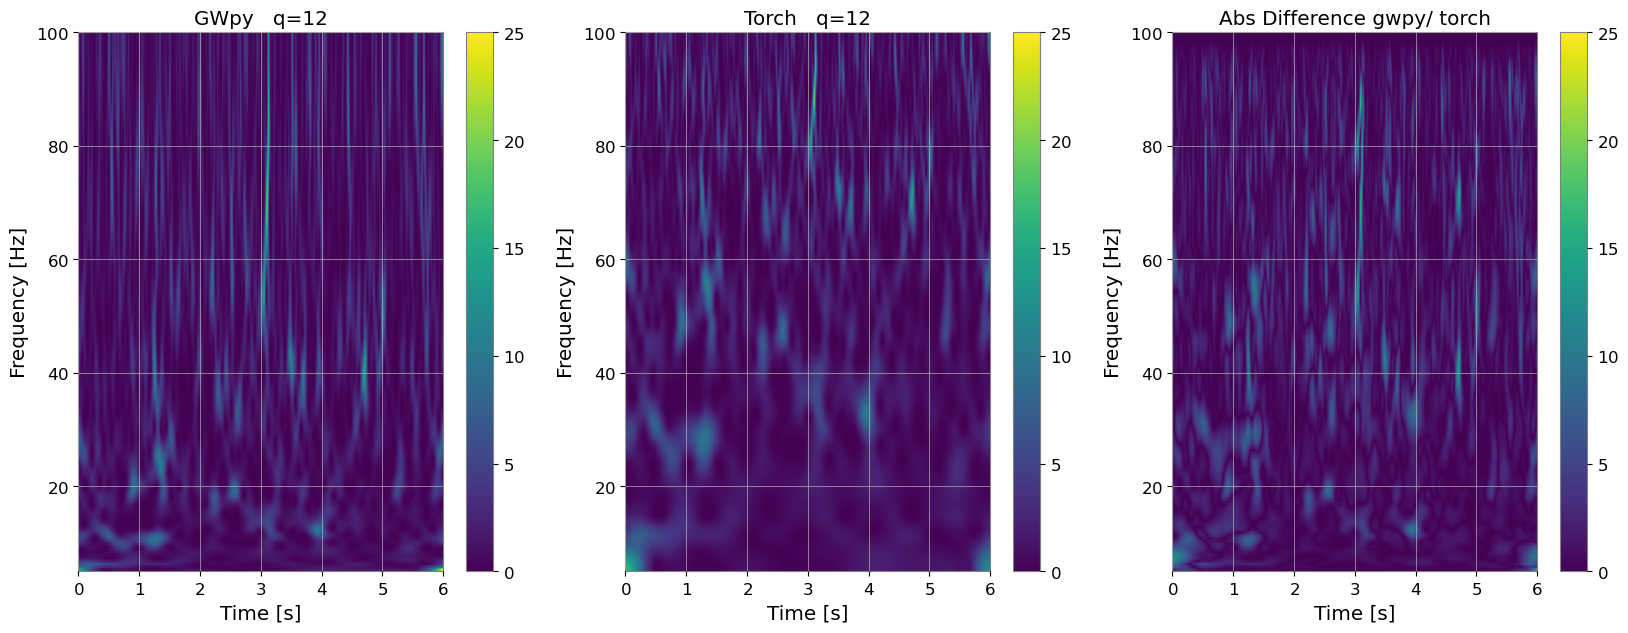

MAX VALUE OF GWPY: 26.004575729370117
MAX VALUE OF TORCH: 19.841341018676758
COORDINATES OF MAX VALUE TORCH: (3.108 s, 88.0 Hz)
COORDINATES OF MAX VALUE GWPY: (5.994 s, 5.0 Hz) 
MEAN OF TORCH PLOT: 1.5075000524520874; STD: 1.6891145706176758
MEAN OF GWPY PLOT: 1.5331716537475586; STD: 1.7138844728469849
MEAN OF ABS DIFF PLOT: 1.4608832597732544; STD: 1.6727641820907593 
MAX OF ABS DIFF PLOT: 19.251296997070312
gwpy_transform.shape=(300, 1000, 190)
type(gwpy_transform)=<class 'numpy.ndarray'>


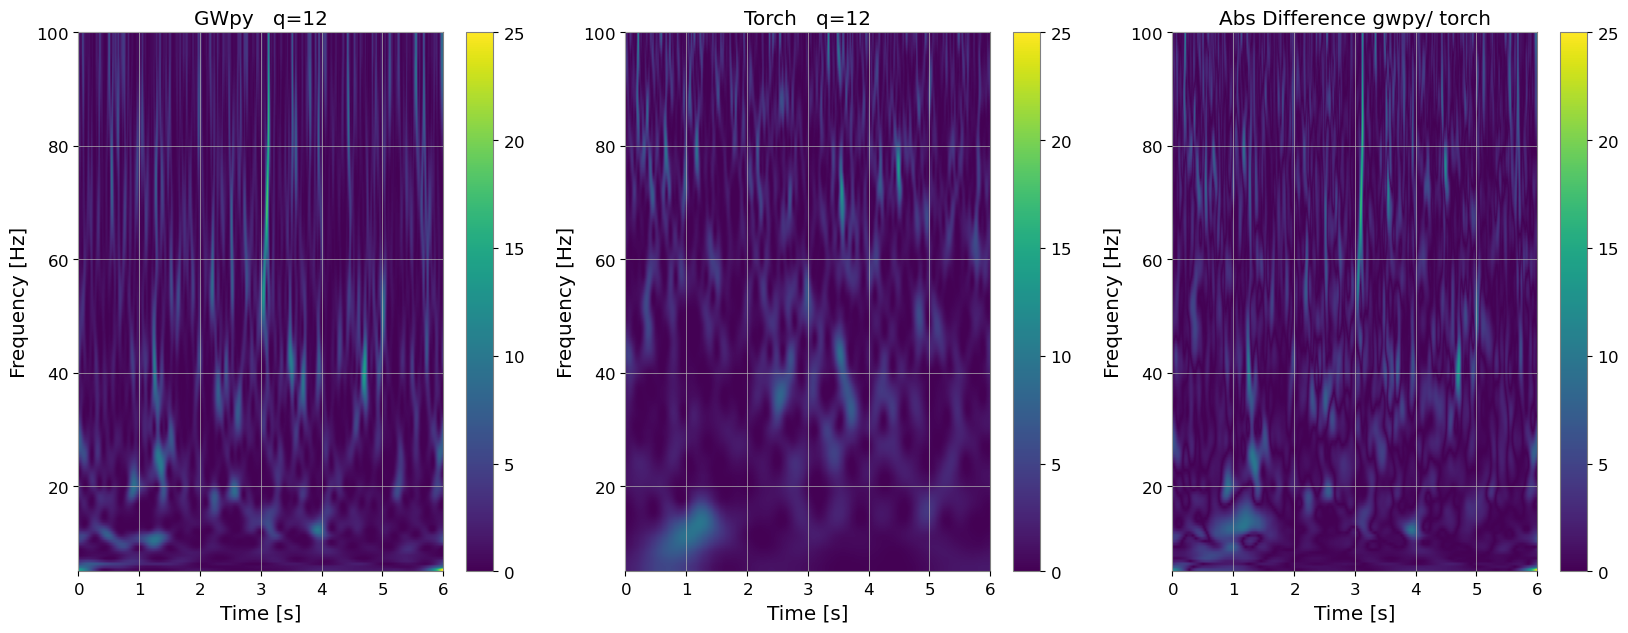

MAX VALUE OF GWPY: 14.357853889465332
MAX VALUE OF TORCH: 13.94143009185791
COORDINATES OF MAX VALUE TORCH: (4.494 s, 75.5 Hz)
COORDINATES OF MAX VALUE GWPY: (5.994 s, 5.0 Hz) 
MEAN OF TORCH PLOT: 1.4248862266540527; STD: 1.4644227027893066
MEAN OF GWPY PLOT: 1.5331716537475586; STD: 1.7138844728469849
MEAN OF ABS DIFF PLOT: 1.468775987625122; STD: 1.6127780675888062 
MAX OF ABS DIFF PLOT: 24.38726043701172
Total time: 15.041230201721191s


In [48]:
#Compute Qtransform
start=time.time() 
gwpy_transform,transformed_2,time_gwpy,time_torch=compute_transforms(df,tensor_long, q=q, frange=frange, sample_rate=sample_rate, qrange=qrange, num_t_bins=num_t_bins, fres=fres,num_processes=10,plot=True,qtiles_mode=False)
end=time.time()
print(f'Total time: {end-start}s')